In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
import multiprocessing
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [2]:
def get_site_distance(a, b):
    dist = min(
        abs(a - b), 16 - abs(a-b)
        ) % 16
    return dist

In [3]:
with open(pickle_dir / 'population_patterns.p', 'rb') as f: 
    population_patterns = pickle.load(f)

# Spatial Dimensionality

### Collect Distance Matrix

In [44]:
def get_distance_mat(fil_string):
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    noncr_hops = population_patterns[fil_string]['noncr_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
    for i, noncr_hop in enumerate(noncr_hops):
        noncr_site = int(exp_data.hop_end_wedges[noncr_hop]) - 1
        if noncr_site == 16: continue
        navig_pattern_mat = hop_patterns[noncr_hop]
        for j, noncr2_hop in enumerate(noncr_hops):
            if j < i: continue
            noncr2_site = int(exp_data.hop_end_wedges[noncr2_hop]) - 1
            if noncr2_site == 16: continue
            navig2_pattern_mat = hop_patterns[noncr2_hop]
            overlaps = []
            for navig2_pattern in navig2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(navig_pattern_mat, navig2_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[noncr_site][noncr2_site].append(max_overlap)
            if i != j:
                distance_matrix[noncr2_site][noncr_site].append(max_overlap)
    return np.array(distance_matrix)

In [ ]:
%%capture
PROCESSES = 5
distance_matrices = []
with multiprocessing.Pool(PROCESSES) as pool:
    params = [p for p in population_patterns.keys()]
    for res in pool.map(get_distance_mat, params):
        distance_matrices.append(res)

In [ ]:
with open(pickle_dir / 'reactivation_place_dist_matrix.p', 'wb') as f:
    pickle.dump(distance_matrices, f)

### Plot raw distance matrices

In [ ]:
with open(pickle_dir / 'reactivation_place_dist_matrix.p', 'rb') as f:
    distance_matrices = pickle.load(f)

In [ ]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
for mat in distance_matrices:
    for i in range(16):
        for j in range(16):
            distance_matrix[i][j].extend(mat[i][j])
distance_matrix = np.array(distance_matrix)

In [ ]:
x = np.zeros(distance_matrix.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j] = np.nanmedian(distance_matrix[i,j])
plt.imshow(x)
plt.ylabel("Navigation")
plt.xlabel("Navigation")
plt.title("Median Overlap")
plt.xticks(np.arange(0, 16, 2), np.arange(0, 16, 2)+1)
plt.yticks(np.arange(0, 16, 2), np.arange(0, 16, 2)+1)
plt.colorbar()

In [ ]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

In [ ]:
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.ylim(0, 1)
plt.title("Navigation/Navigation Overlap")
plt.xlabel("Site Distance between\nHops")
plt.ylabel("Median Overlap")
plt.show()

# Cache v Cache Dimensionality

### Collect Distance Matrix

In [4]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, c_hop in enumerate(c_hops):
        c_site = int(exp_data.event_sites[exp_data.cache_event][i]) - 1
        cache_pattern_mat = hop_patterns[c_hop]
        for j, c2_hop in enumerate(c_hops):
            if j <= i: continue
            c2_site = int(exp_data.event_sites[exp_data.cache_event][j]) - 1
            cache2_pattern_mat = hop_patterns[c2_hop]
            overlaps = []
            for cache2_pattern in cache2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, cache2_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[c_site][c2_site].append(max_overlap)
            if i != j:
                distance_matrix[c2_site][c_site].append(max_overlap)
distance_matrix = np.array(distance_matrix)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: All-NaN axis encountered


### Plot raw distance matrices

In [5]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


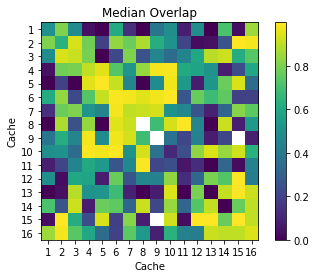

In [6]:
# Plot heatmap
x = np.zeros(distance_matrix.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j] = np.nanmedian(distance_matrix[i,j])
plt.imshow(x)
plt.ylabel("Cache")
plt.xlabel("Cache")
plt.xticks(np.arange(16), np.arange(16)+1)
plt.yticks(np.arange(16), np.arange(16)+1)
plt.colorbar()
plt.title("Median Overlap")
plt.show()

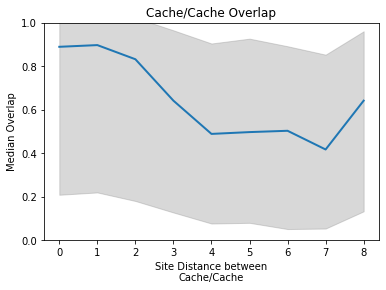

In [7]:
# Collapse onto 1D
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.fill_between(
    np.arange(9),
    [np.nanmean(v) + np.nanstd(v) for v in vals_by_sitedist],
    [np.nanmean(v) - np.nanstd(v) for v in vals_by_sitedist],
    color="gray", alpha=0.3
    )
plt.ylim(0, 1)
plt.title("Cache/Cache Overlap")
plt.xlabel("Site Distance between\nCache/Cache")
plt.ylabel("Median Overlap")
plt.show()

# Cache v Retrieval Dimensionality

### Collect Distance Matrix

In [4]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
count = 0
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, c_hop in enumerate(c_hops):
        c_site = int(exp_data.event_sites[exp_data.cache_event][i]) - 1
        cache_pattern_mat = hop_patterns[c_hop]
        retrieved = False
        for j, r_hop in enumerate(r_hops):
            r_site = int(exp_data.event_sites[exp_data.retriev_event][j]) - 1
            retriev_pattern_mat = hop_patterns[r_hop]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, retriev_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[c_site][r_site].append(max_overlap)
            count += 1
distance_matrix = np.array(distance_matrix)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: All-NaN slice encountered


In [5]:
count

2027

### Plot raw distance matrices

In [8]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


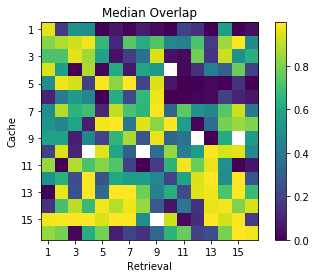

In [9]:
# Plot heatmap
x = np.zeros(distance_matrix.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j] = np.nanmedian(distance_matrix[i,j])
plt.imshow(x)
plt.ylabel("Cache")
plt.xlabel("Retrieval")
plt.xticks(np.arange(0,16,2), np.arange(0,16,2)+1)
plt.yticks(np.arange(0,16,2), np.arange(0,16,2)+1)
plt.title("Median Overlap")
plt.colorbar()

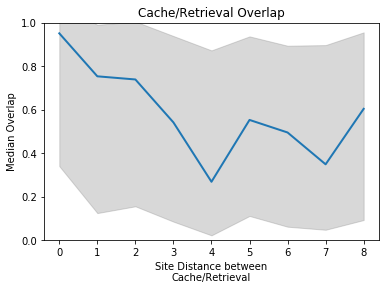

In [10]:
# Collapse onto 1D
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.fill_between(
    np.arange(9),
    [np.nanmean(v) + np.nanstd(v) for v in vals_by_sitedist],
    [np.nanmean(v) - np.nanstd(v) for v in vals_by_sitedist],
    color="gray", alpha=0.3
    )
plt.ylim(0, 1)
plt.title("Cache/Retrieval Overlap")
plt.xlabel("Site Distance between\nCache/Retrieval")
plt.ylabel("Median Overlap")
plt.show()

# Cache v Navigation Dimensionality
(Using Cache "Memory")

### Collect Distance Matrix

In [55]:
with open(pickle_dir / 'episode_cells_overlap.p', 'rb') as f:
    episode_cells = pickle.load(f)

In [56]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
counts = np.zeros((16, 16))
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncr_hops = population_patterns[fil_string]['noncr_hops']
    fr = population_patterns[fil_string]['fr']
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    cr_idx_mat = episode_cells[fil_string]['cr_idx_mat']
    for i, c_hop in enumerate(c_hops):
        c_site = exp_data.event_sites[exp_data.cache_event][i]
        c_site = int(c_site) - 1
        cache_pattern = cr_idx_mat[i]
        cache_pattern[np.isnan(cache_pattern)] = 0
        if np.sum(cache_pattern) == 0: continue
        for j, noncr_hop in enumerate(noncr_hops):
            overlaps = []
            noncr_site = exp_data.hop_end_wedges[noncr_hop]
            noncr_site = int(noncr_site) - 1
            if noncr_site == 16: continue
            navig_pattern_mat = hop_patterns[noncr_hop]
            for navig_pattern in navig_pattern_mat.T:
                overlaps.append(
                    popln_overlap(cache_pattern[:,None], navig_pattern)[0]
                    )
            max_overlap = np.nanmax(overlaps)
            distance_matrix[c_site][noncr_site].append(max_overlap)
            counts[c_site][noncr_site] += 1
distance_matrix = np.array(distance_matrix)

### Plot raw distance matrices

In [57]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

In [ ]:
# Plot heatmap
x = np.zeros(distance_matrix.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j] = np.nanmedian(distance_matrix[i,j])
plt.imshow(x)
plt.ylabel("Cache")
plt.xlabel("Arbitrary Hop")
plt.xticks(np.arange(0,16,2), np.arange(0,16,2)+1)
plt.yticks(np.arange(0,16,2), np.arange(0,16,2)+1)
plt.title("Median Overlap")
plt.clim(0, 0.8)
plt.colorbar()

In [ ]:
# Collapse onto 1D
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.fill_between(
    np.arange(9),
    [np.nanmean(v) + np.nanstd(v) for v in vals_by_sitedist],
    [np.nanmean(v) - np.nanstd(v) for v in vals_by_sitedist],
    color="gray", alpha=0.3
    )
plt.ylim(0, 1)
plt.title("Cache/Navigation Overlap")
plt.xlabel("Site Distance between\nCache/Navigation")
plt.ylabel("Median Overlap")
plt.show()

# Control: Spatial Dimensionality with Subsampling

### Collect Distance Matrix

In [13]:
distance_matrix = [[[] for _ in range(16)] for _ in range(16)]
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_hops = population_patterns[fil_string]['c_hops']
    r_hops = population_patterns[fil_string]['r_hops']
    noncr_hops = population_patterns[fil_string]['noncr_hops']
    noncr_sites = exp_data.hop_end_wedges[noncr_hops] - 1 
    hop_patterns = population_patterns[fil_string]['hop_patterns']
    for i, c_hop in enumerate(c_hops):
        c_site = int(exp_data.event_sites[exp_data.cache_event][i]) - 1
        shuff_c_hop = np.random.choice(
            noncr_hops[noncr_sites==c_site]
            )
        cache_pattern_mat = hop_patterns[shuff_c_hop]
        for j, r_hop in enumerate(r_hops):
            r_site = int(exp_data.event_sites[exp_data.retriev_event][j]) - 1
            shuff_r_hop = np.random.choice(
                noncr_hops[noncr_sites==r_site]
                )
            retriev_pattern_mat = hop_patterns[shuff_r_hop]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, retriev_pattern)
                    ))
            max_overlap = np.nanmax(overlaps)
            distance_matrix[c_site][r_site].append(max_overlap)
distance_matrix = np.array(distance_matrix)

/home/chingf/Code/cache-arena-analysis/analysis/utils.py:49: RuntimeWarning: invalid value encountered in true_divide
  dist = adotb/(asumsq + bsumsq - adotb)
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN axis encountered


### Plot raw distance matrices

In [14]:
vals_by_sitedist = [[] for _ in range(9)]
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        mat_ij = np.array(distance_matrix[i,j])
        nonnan_vals = mat_ij[np.logical_not(np.isnan(mat_ij))].tolist()
        dist = get_site_distance(i,j)
        vals_by_sitedist[dist].extend(nonnan_vals)

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


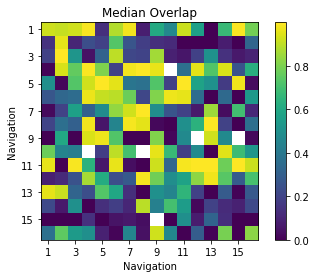

In [15]:
# Plot heatmap
x = np.zeros(distance_matrix.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i,j] = np.nanmedian(distance_matrix[i,j])
plt.imshow(x)
plt.ylabel("Navigation")
plt.xlabel("Navigation")
plt.xticks(np.arange(0,16,2), np.arange(0,16,2)+1)
plt.yticks(np.arange(0,16,2), np.arange(0,16,2)+1)
plt.title("Median Overlap")
plt.colorbar()

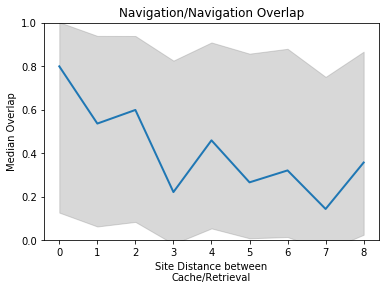

In [16]:
# Collapse onto 1D
plt.plot(
    np.arange(9), [np.nanmedian(v) for v in vals_by_sitedist],
    linewidth=2
    )
plt.fill_between(
    np.arange(9),
    [np.nanmean(v) + np.nanstd(v) for v in vals_by_sitedist],
    [np.nanmean(v) - np.nanstd(v) for v in vals_by_sitedist],
    color="gray", alpha=0.3
    )
plt.ylim(0, 1)
plt.title("Navigation/Navigation Overlap")
plt.xlabel("Site Distance between\nCache/Retrieval")
plt.ylabel("Median Overlap")
plt.show()